<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [1]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

##Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [3]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [4]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [5]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,1.134883,1.310939,-1.656313,-0.590618,0.296509,-0.606985
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-0.564614,-0.034865
2023-01-05,-2.264395,0.949383,2.979359,0.821214,-0.152961,0.602539
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,1.377315,0.185566
2023-01-07,0.756396,0.669974,-0.050230,0.731974,1.359194,0.126406
2023-01-08,0.179409,0.684908,-1.945460,0.507623,1.658180,1.636336


In [6]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [7]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [8]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [9]:
df.head()

,A,B,C,D,E,F
2023-01-01,1.134883,1.310939,-1.656313,-0.590618,0.296509,-0.606985
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-0.564614,-0.034865
2023-01-05,-2.264395,0.949383,2.979359,0.821214,-0.152961,0.602539


In [10]:
df.tail()

,A,B,C,D,E,F
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-0.564614,-0.034865
2023-01-05,-2.264395,0.949383,2.979359,0.821214,-0.152961,0.602539
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,1.377315,0.185566
2023-01-07,0.756396,0.669974,-0.050230,0.731974,1.359194,0.126406
2023-01-08,0.179409,0.684908,-1.945460,0.507623,1.658180,1.636336


In [11]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [12]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [13]:
df.to_numpy()

array([[ 1.13488275,  1.31093863, -1.65631265, -0.59061792,  0.29650933,
        -0.60698513],
       [-0.50865022,  0.14367852, -0.1796499 ,  1.41243911, -0.5083306 ,
         2.4267577 ],
       [ 0.67075819, -0.68417882,  0.73907195, -0.33873924, -2.57804122,
        -0.84107766],
       [-1.60097395, -0.26362587, -1.28869525, -0.30849253, -0.56461351,
        -0.03486479],
       [-2.26439479,  0.9493832 ,  2.97935924,  0.82121408, -0.15296083,
         0.60253854],
       [ 1.313451  , -0.6103654 , -0.22042628,  0.48712497,  1.37731458,
         0.18556576],
       [ 0.7563962 ,  0.66997362, -0.05022976,  0.73197353,  1.35919359,
         0.12640597],
       [ 0.17940885,  0.68490782, -1.94546038,  0.50762294,  1.65818009,
         1.63633585]])

In [14]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [15]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.039890,0.275089,-0.202793,0.340316,0.110906,0.436835
std,1.309523,0.742895,1.575079,0.689965,1.400529,1.103933
min,-2.264395,-0.684179,-1.945460,-0.590618,-2.578041,-0.841078
25%,-0.781731,-0.350311,-1.380600,-0.316054,-0.522401,-0.177895
50%,0.425084,0.406826,-0.200038,0.497374,0.071774,0.155986
75%,0.851018,0.751027,0.147096,0.754284,1.363724,0.860988
max,1.313451,1.310939,2.979359,1.412439,1.658180,2.426758


In [16]:
df

,A,B,C,D,E,F
2023-01-01,1.134883,1.310939,-1.656313,-0.590618,0.296509,-0.606985
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-0.564614,-0.034865
2023-01-05,-2.264395,0.949383,2.979359,0.821214,-0.152961,0.602539
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,1.377315,0.185566
2023-01-07,0.756396,0.669974,-0.050230,0.731974,1.359194,0.126406
2023-01-08,0.179409,0.684908,-1.945460,0.507623,1.658180,1.636336


In [17]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,1.134883,-0.508650,0.670758,-1.600974,-2.264395,1.313451,0.756396,0.179409
B,1.310939,0.143679,-0.684179,-0.263626,0.949383,-0.610365,0.669974,0.684908
C,-1.656313,-0.179650,0.739072,-1.288695,2.979359,-0.220426,-0.050230,-1.945460
D,-0.590618,1.412439,-0.338739,-0.308493,0.821214,0.487125,0.731974,0.507623
E,0.296509,-0.508331,-2.578041,-0.564614,-0.152961,1.377315,1.359194,1.658180
F,-0.606985,2.426758,-0.841078,-0.034865,0.602539,0.185566,0.126406,1.636336


In [18]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,-0.606985,0.296509,-0.590618,-1.656313,1.310939,1.134883
2023-01-02,2.426758,-0.508331,1.412439,-0.179650,0.143679,-0.508650
2023-01-03,-0.841078,-2.578041,-0.338739,0.739072,-0.684179,0.670758
2023-01-04,-0.034865,-0.564614,-0.308493,-1.288695,-0.263626,-1.600974
2023-01-05,0.602539,-0.152961,0.821214,2.979359,0.949383,-2.264395
2023-01-06,0.185566,1.377315,0.487125,-0.220426,-0.610365,1.313451
2023-01-07,0.126406,1.359194,0.731974,-0.050230,0.669974,0.756396
2023-01-08,1.636336,1.658180,0.507623,-1.945460,0.684908,0.179409


In [19]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,1.377315,0.185566
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-0.564614,-0.034865
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758
2023-01-07,0.756396,0.669974,-0.050230,0.731974,1.359194,0.126406
2023-01-08,0.179409,0.684908,-1.945460,0.507623,1.658180,1.636336
2023-01-05,-2.264395,0.949383,2.979359,0.821214,-0.152961,0.602539
2023-01-01,1.134883,1.310939,-1.656313,-0.590618,0.296509,-0.606985


In [20]:
df

,A,B,C,D,E,F
2023-01-01,1.134883,1.310939,-1.656313,-0.590618,0.296509,-0.606985
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-0.564614,-0.034865
2023-01-05,-2.264395,0.949383,2.979359,0.821214,-0.152961,0.602539
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,1.377315,0.185566
2023-01-07,0.756396,0.669974,-0.050230,0.731974,1.359194,0.126406
2023-01-08,0.179409,0.684908,-1.945460,0.507623,1.658180,1.636336


##Getting

In [21]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01    1.134883
2023-01-02   -0.508650
2023-01-03    0.670758
2023-01-04   -1.600974
2023-01-05   -2.264395
2023-01-06    1.313451
2023-01-07    0.756396
2023-01-08    0.179409
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [22]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,1.134883,1.310939,-1.656313,-0.590618,0.296509,-0.606985
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078


In [23]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-0.564614,-0.034865


In [24]:
df

,A,B,C,D,E,F
2023-01-01,1.134883,1.310939,-1.656313,-0.590618,0.296509,-0.606985
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-0.564614,-0.034865
2023-01-05,-2.264395,0.949383,2.979359,0.821214,-0.152961,0.602539
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,1.377315,0.185566
2023-01-07,0.756396,0.669974,-0.050230,0.731974,1.359194,0.126406
2023-01-08,0.179409,0.684908,-1.945460,0.507623,1.658180,1.636336


##Selection by label

In [25]:
df.loc[dates[1]]

A   -0.508650
B    0.143679
C   -0.179650
D    1.412439
E   -0.508331
F    2.426758
Name: 2023-01-02 00:00:00, dtype: float64

In [26]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,1.134883,-0.590618
2023-01-02,-0.508650,1.412439
2023-01-03,0.670758,-0.338739
2023-01-04,-1.600974,-0.308493
2023-01-05,-2.264395,0.821214
2023-01-06,1.313451,0.487125
2023-01-07,0.756396,0.731974
2023-01-08,0.179409,0.507623


In [27]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,-1.600974,-0.308493
2023-01-05,-2.264395,0.821214
2023-01-06,1.313451,0.487125


In [28]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A   -1.600974
D   -0.308493
Name: 2023-01-04 00:00:00, dtype: float64

In [29]:
# For getting a scalar value
df.loc[dates[1], "D"]

1.4124391079408625

In [30]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

1.4124391079408625

##Selection by position

In [31]:
df.iloc[3]

A   -1.600974
B   -0.263626
C   -1.288695
D   -0.308493
E   -0.564614
F   -0.034865
Name: 2023-01-04 00:00:00, dtype: float64

In [32]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,-1.600974,-0.263626
2023-01-05,-2.264395,0.949383


In [33]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,-0.508650,-0.179650
2023-01-03,0.670758,0.739072
2023-01-05,-2.264395,2.979359


In [34]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078


In [35]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,1.310939,-1.656313
2023-01-02,0.143679,-0.179650
2023-01-03,-0.684179,0.739072
2023-01-04,-0.263626,-1.288695
2023-01-05,0.949383,2.979359
2023-01-06,-0.610365,-0.220426
2023-01-07,0.669974,-0.050230
2023-01-08,0.684908,-1.945460


In [36]:
# For getting values explicitly
df.iloc[1, 1]

0.14367852331976042

In [37]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

0.14367852331976042

## Boolean indexing
Using a single column's values to select data:

In [38]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-01,1.134883,1.310939,-1.656313,-0.590618,0.296509,-0.606985
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,1.377315,0.185566
2023-01-07,0.756396,0.669974,-0.050230,0.731974,1.359194,0.126406
2023-01-08,0.179409,0.684908,-1.945460,0.507623,1.658180,1.636336


In [39]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,1.134883,1.310939,NaN,NaN,0.296509,NaN
2023-01-02,NaN,0.143679,NaN,1.412439,NaN,2.426758
2023-01-03,0.670758,NaN,0.739072,NaN,NaN,NaN
2023-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-05,NaN,0.949383,2.979359,0.821214,NaN,0.602539
2023-01-06,1.313451,NaN,NaN,0.487125,1.377315,0.185566
2023-01-07,0.756396,0.669974,NaN,0.731974,1.359194,0.126406
2023-01-08,0.179409,0.684908,NaN,0.507623,1.658180,1.636336


In [40]:
df

,A,B,C,D,E,F
2023-01-01,1.134883,1.310939,-1.656313,-0.590618,0.296509,-0.606985
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-0.564614,-0.034865
2023-01-05,-2.264395,0.949383,2.979359,0.821214,-0.152961,0.602539
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,1.377315,0.185566
2023-01-07,0.756396,0.669974,-0.050230,0.731974,1.359194,0.126406
2023-01-08,0.179409,0.684908,-1.945460,0.507623,1.658180,1.636336


In [41]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,1.134883,1.310939,-1.656313,-0.590618,0.296509,-0.606985,one
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758,one
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078,two
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-0.564614,-0.034865,three
2023-01-05,-2.264395,0.949383,2.979359,0.821214,-0.152961,0.602539,four
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,1.377315,0.185566,three
2023-01-07,0.756396,0.669974,-0.050230,0.731974,1.359194,0.126406,five
2023-01-08,0.179409,0.684908,-1.945460,0.507623,1.658180,1.636336,four


In [42]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078,two
2023-01-05,-2.264395,0.949383,2.979359,0.821214,-0.152961,0.602539,four
2023-01-08,0.179409,0.684908,-1.945460,0.507623,1.658180,1.636336,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [43]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [44]:
df["G"] = s1

In [45]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [46]:
# Setting values by position:
df.iat[0, 1] = 0

In [47]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-1.656313,-0.590618,0.296509,-0.606985,NaN
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,-0.508331,2.426758,1.0
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,-2.578041,-0.841078,2.0
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-0.564614,-0.034865,3.0
2023-01-05,-2.264395,0.949383,2.979359,0.821214,-0.152961,0.602539,4.0
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,1.377315,0.185566,5.0
2023-01-07,0.756396,0.669974,-0.050230,0.731974,1.359194,0.126406,6.0
2023-01-08,0.179409,0.684908,-1.945460,0.507623,1.658180,1.636336,NaN


In [48]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [49]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-1.656313,-0.590618,5,-0.606985,NaN
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,5,2.426758,1.0
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,5,-0.841078,2.0
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,5,-0.034865,3.0
2023-01-05,-2.264395,0.949383,2.979359,0.821214,5,0.602539,4.0
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,5,0.185566,5.0
2023-01-07,0.756396,0.669974,-0.050230,0.731974,5,0.126406,6.0
2023-01-08,0.179409,0.684908,-1.945460,0.507623,5,1.636336,NaN


In [50]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-1.656313,-0.590618,-5,-0.606985,NaN
2023-01-02,-0.508650,-0.143679,-0.179650,-1.412439,-5,-2.426758,-1.0
2023-01-03,-0.670758,-0.684179,-0.739072,-0.338739,-5,-0.841078,-2.0
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,-5,-0.034865,-3.0
2023-01-05,-2.264395,-0.949383,-2.979359,-0.821214,-5,-0.602539,-4.0
2023-01-06,-1.313451,-0.610365,-0.220426,-0.487125,-5,-0.185566,-5.0
2023-01-07,-0.756396,-0.669974,-0.050230,-0.731974,-5,-0.126406,-6.0
2023-01-08,-0.179409,-0.684908,-1.945460,-0.507623,-5,-1.636336,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [51]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-1.656313,-0.590618,5,-0.606985,1.0,1.0
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,5,2.426758,1.0,1.0
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,5,-0.841078,2.0,2.0
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,5,-0.034865,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [52]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-1.656313,-0.590618,5,-0.606985,1.0,1.0
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,5,2.426758,1.0,1.0
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,5,-0.841078,2.0,2.0
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,5,-0.034865,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [53]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-1.656313,-0.590618,5,-0.606985,1.0,1.0
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,5,2.426758,1.0,1.0
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,5,-0.841078,2.0,2.0
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,5,-0.034865,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [54]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [55]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-1.656313,-0.590618,5,-0.606985,NaN
2023-01-02,-0.508650,0.143679,-0.179650,1.412439,5,2.426758,1.0
2023-01-03,0.670758,-0.684179,0.739072,-0.338739,5,-0.841078,2.0
2023-01-04,-1.600974,-0.263626,-1.288695,-0.308493,5,-0.034865,3.0
2023-01-05,-2.264395,0.949383,2.979359,0.821214,5,0.602539,4.0
2023-01-06,1.313451,-0.610365,-0.220426,0.487125,5,0.185566,5.0
2023-01-07,0.756396,0.669974,-0.050230,0.731974,5,0.126406,6.0
2023-01-08,0.179409,0.684908,-1.945460,0.507623,5,1.636336,NaN


In [56]:
df.mean()

A   -0.181751
B    0.111222
C   -0.202793
D    0.340316
E    5.000000
F    0.436835
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [57]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [58]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-0.329242,-1.684179,-0.260928,-1.338739,4.0,-1.841078,1.0
2023-01-04,-4.600974,-3.263626,-4.288695,-3.308493,2.0,-3.034865,0.0
2023-01-05,-6.264395,-3.050617,-1.020641,-3.178786,1.0,-3.397461,0.0
2023-01-06,-3.686549,-5.610365,-5.220426,-4.512875,0.0,-4.814434,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-5.820591,-5.315092,-7.945460,-5.492377,-1.0,-4.363664,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [59]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-1.656313,-0.590618,5,-0.606985,NaN
2023-01-02,-0.508650,0.143679,-1.835963,0.821821,10,1.819773,1.0
2023-01-03,0.162108,-0.540500,-1.096891,0.483082,15,0.978695,3.0
2023-01-04,-1.438866,-0.804126,-2.385586,0.174589,20,0.943830,6.0
2023-01-05,-3.703261,0.145257,0.593773,0.995803,25,1.546369,10.0
2023-01-06,-2.389810,-0.465108,0.373347,1.482928,30,1.731934,15.0
2023-01-07,-1.633414,0.204865,0.323117,2.214902,35,1.858340,21.0
2023-01-08,-1.454005,0.889773,-1.622343,2.722525,40,3.494676,NaN


In [60]:
df.apply(lambda x: x.max() - x.min())

A    3.577846
B    1.633562
C    4.924820
D    2.003057
E    0.000000
F    3.267835
G    5.000000
dtype: float64

##Histogramming

In [61]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    6
1    6
2    5
3    0
4    6
5    3
6    6
7    4
8    1
9    3
dtype: int64

In [62]:
s.value_counts()

6    4
3    2
5    1
0    1
4    1
1    1
dtype: int64

##String Methods


In [63]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [64]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,1.819099,-1.032211,0.630506,-0.320407
1,0.647389,1.989836,-0.208467,0.247577
2,0.096783,-0.949130,-0.920506,0.602576
3,1.746282,0.326019,0.756657,0.012342
4,-0.116196,-0.030221,-0.101759,0.143042
5,0.804166,-0.166025,-0.576099,0.134581
6,-0.664656,-1.101473,0.623239,-0.960340
7,-0.033945,0.050430,-0.341622,0.958231
8,-0.100947,1.959722,-0.839500,0.613685
9,0.561678,1.803880,-0.339461,0.477932


In [65]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,1.819099,-1.032211,0.630506,-0.320407
1,0.647389,1.989836,-0.208467,0.247577
2,0.096783,-0.949130,-0.920506,0.602576
3,1.746282,0.326019,0.756657,0.012342
4,-0.116196,-0.030221,-0.101759,0.143042
5,0.804166,-0.166025,-0.576099,0.134581
6,-0.664656,-1.101473,0.623239,-0.960340
7,-0.033945,0.050430,-0.341622,0.958231
8,-0.100947,1.959722,-0.839500,0.613685
9,0.561678,1.803880,-0.339461,0.477932


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [66]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [67]:
right

,key,rval
0,foo,4
1,foo,5


In [68]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [69]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [70]:
right

,key,rval
0,foo,4
1,bar,5


In [71]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [72]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,1.197446,0.077966
1,bar,one,0.280992,0.137631
2,foo,two,1.649680,0.023186
3,bar,three,-0.844236,0.160971
4,foo,two,1.077555,-0.310765
5,bar,two,-0.455769,-0.321613
6,foo,one,1.706525,-0.088348
7,foo,three,-0.365536,-0.994449


Grouping and then applying the `sum()` function to the resulting groups:

In [73]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,-1.019013,-0.02301
foo,5.265670,-1.29241


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [74]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one    0.280992  0.137631
    three -0.844236  0.160971
    two   -0.455769 -0.321613
foo one    2.903972 -0.010382
    three -0.365536 -0.994449
    two    2.727234 -0.287579

##Reshaping
**Stack**

In [75]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one     0.677943 -0.904416
      two     1.548230  0.574276
baz   one    -0.467545 -0.075853
      two    -0.058929 -0.704333

The `stack()` method "compresses" a level in the DataFrame's columns:

In [76]:
stacked = df2.stack()
stacked

first  second   
bar    one     A    0.677943
               B   -0.904416
       two     A    1.548230
               B    0.574276
baz    one     A   -0.467545
               B   -0.075853
       two     A   -0.058929
               B   -0.704333
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [77]:
stacked.unstack()

A         B
first second                    
bar   one     0.677943 -0.904416
      two     1.548230  0.574276
baz   one    -0.467545 -0.075853
      two    -0.058929 -0.704333

In [78]:
stacked.unstack(1)

second        one       two
first                      
bar   A  0.677943  1.548230
      B -0.904416  0.574276
baz   A -0.467545 -0.058929
      B -0.075853 -0.704333

In [79]:
stacked.unstack(0)

first          bar       baz
second                      
one    A  0.677943 -0.467545
       B -0.904416 -0.075853
two    A  1.548230 -0.058929
       B  0.574276 -0.704333

##Pivot tables

In [80]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,0.234260,0.399368
1,one,B,foo,-1.867654,-1.351231
2,two,C,foo,0.328322,0.496894
3,three,A,bar,-0.112843,2.025096
4,one,B,bar,-0.889812,-0.963293
5,one,C,bar,0.865999,-0.566248
6,two,A,foo,-0.135754,-0.789366
7,three,B,foo,-0.433082,0.310067
8,one,C,foo,1.019712,0.295728
9,one,A,bar,-1.194723,0.014667


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [81]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A -1.194723  0.234260
      B -0.889812 -1.867654
      C  0.865999  1.019712
three A -0.112843       NaN
      B       NaN -0.433082
      C -0.535486       NaN
two   A       NaN -0.135754
      B -0.741416       NaN
      C       NaN  0.328322

##Time series

In [82]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    25364
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [83]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06    0.064496
2012-03-07    0.816468
2012-03-08    1.359857
2012-03-09    0.930029
2012-03-10   -0.970529
Freq: D, dtype: float64

In [84]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00    0.064496
2012-03-07 00:00:00+00:00    0.816468
2012-03-08 00:00:00+00:00    1.359857
2012-03-09 00:00:00+00:00    0.930029
2012-03-10 00:00:00+00:00   -0.970529
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [85]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00    0.064496
2012-03-06 19:00:00-05:00    0.816468
2012-03-07 19:00:00-05:00    1.359857
2012-03-08 19:00:00-05:00    0.930029
2012-03-09 19:00:00-05:00   -0.970529
Freq: D, dtype: float64

Converting between time span representations:

In [86]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31   -0.629230
2012-02-29   -0.588580
2012-03-31   -0.487397
2012-04-30   -1.441051
2012-05-31    0.023474
Freq: M, dtype: float64

In [87]:
ps = ts.to_period()

ps 

2012-01   -0.629230
2012-02   -0.588580
2012-03   -0.487397
2012-04   -1.441051
2012-05    0.023474
Freq: M, dtype: float64

In [88]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01   -0.629230
2012-02-01   -0.588580
2012-03-01   -0.487397
2012-04-01   -1.441051
2012-05-01    0.023474
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [89]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00    0.777452
1990-06-01 09:00   -0.631581
1990-09-01 09:00   -0.855847
1990-12-01 09:00    1.493577
1991-03-01 09:00   -1.642012
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [90]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [91]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [92]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [93]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [94]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [95]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [96]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

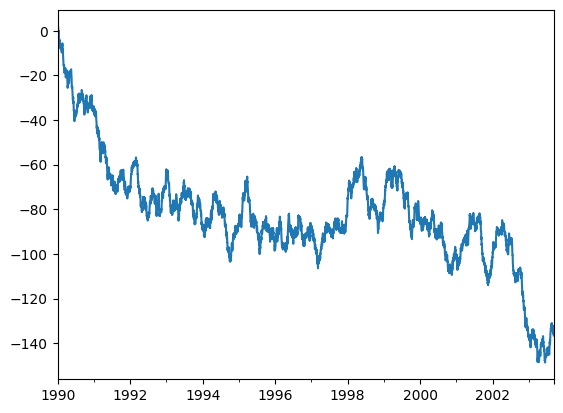

In [97]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [98]:
plt.show();

<Figure size 640x480 with 0 Axes>

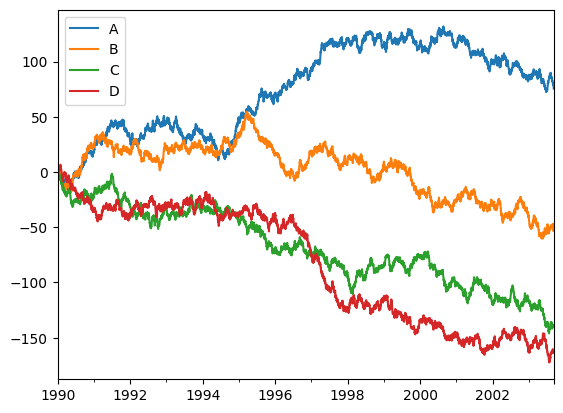

In [99]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [100]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [101]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,-1.832072,-0.355192,-0.004189,-1.159001
1,1990-01-02,-1.163593,1.053453,-0.369305,0.740733
2,1990-01-03,-2.196905,1.707074,1.053250,2.022557
3,1990-01-04,-1.640798,2.341982,0.259785,0.359851
4,1990-01-05,-2.197566,3.563815,1.059652,0.896053
...,...,...,...,...,...
4995,2003-09-05,80.185333,-51.792145,-139.308086,-163.169196
4996,2003-09-06,78.910303,-51.583713,-138.249399,-163.519044
4997,2003-09-07,78.482597,-53.300231,-139.605796,-162.660548
4998,2003-09-08,76.076537,-52.526379,-138.526722,-162.691952


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [102]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [103]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,-1.832072,-0.355192,-0.004189,-1.159001
1990-01-02,-1.163593,1.053453,-0.369305,0.740733
1990-01-03,-2.196905,1.707074,1.053250,2.022557
1990-01-04,-1.640798,2.341982,0.259785,0.359851
1990-01-05,-2.197566,3.563815,1.059652,0.896053
...,...,...,...,...
2003-09-05,80.185333,-51.792145,-139.308086,-163.169196
2003-09-06,78.910303,-51.583713,-138.249399,-163.519044
2003-09-07,78.482597,-53.300231,-139.605796,-162.660548
2003-09-08,76.076537,-52.526379,-138.526722,-162.691952


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [104]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [105]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,-1.832072,-0.355192,-0.004189,-1.159001
1,1990-01-02,-1.163593,1.053453,-0.369305,0.740733
2,1990-01-03,-2.196905,1.707074,1.053250,2.022557
3,1990-01-04,-1.640798,2.341982,0.259785,0.359851
4,1990-01-05,-2.197566,3.563815,1.059652,0.896053
...,...,...,...,...,...
4995,2003-09-05,80.185333,-51.792145,-139.308086,-163.169196
4996,2003-09-06,78.910303,-51.583713,-138.249399,-163.519044
4997,2003-09-07,78.482597,-53.300231,-139.605796,-162.660548
4998,2003-09-08,76.076537,-52.526379,-138.526722,-162.691952


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [106]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a   -0.502167
b    2.598109
c    0.907158
d   -1.255564
e   -0.698225
dtype: float64

In [107]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [108]:
pd.Series(np.random.randn(5))

0   -2.958110
1   -0.060640
2    0.642204
3   -0.824559
4   -2.632967
dtype: float64

**From dict**
`Series` can be instantiated from dicts:

In [109]:
d = {"d":1, "a": 0, "c": 2}
pd.Series(d)

d    1
a    0
c    2
dtype: int64

In [110]:
# If an index is passed, the values in data corresponding to the labels in the index will be returned:

d = {"a": 0.0, "b": 1.0, "c": 2.0}

pd.Series(d)

a    0.0
b    1.0
c    2.0
dtype: float64

In [111]:
pd.Series(d, index=["b", "c", "d", "a"])

b    1.0
c    2.0
d    NaN
a    0.0
dtype: float64

**From scalar value**

If `data` is a scalar value, an index must be provided. The value will be repeated to match the length of the index.

In [112]:
pd.Series( '5a', index=["a", "b", "c", "d", "e"])

a    5a
b    5a
c    5a
d    5a
e    5a
dtype: object

In [113]:
s[s>s.median()]

b    2.598109
c    0.907158
dtype: float64

In [114]:

import openpyxl
import xlrd
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls")

,TABLE 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"SALIENT CEMENT STATISTICS1, 2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(Thousand metric tons unless otherwise specified),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2014.0,2015.0,2016.0,2017.0,2018.0
5,United States:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Production:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cement3,NaN,NaN,82535.0,84405.0,84695.0,86356.0,86400.0
8,Clinker,NaN,NaN,74372.0,76043.0,75633.0,76678.0,77112.0
9,"Shipments from mills and terminals:3, 4",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
def cfun(x):
    return int(x) if x else -1
    
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release.xlsx", "Table1", usecols="A,B:G", converters={"MyInts": cfun})

,"Table 1. Value of Construction Put in Place in the United States, Seasonally Adjusted Annual Rate",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(Millions of dollars. Details may not add to t...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,"lodging, religious, communication, and manufac...",NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,"Data are at an annual rate, adjusted for seaso...",NaN,NaN,NaN,NaN,NaN,NaN
75,Table 3 provides estimated measures of samplin...,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
bb = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release1.xlsx", "Sheet1", dtype={"MyInts": "Int64Dtype()", "MyText": str})
bb

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1


In [117]:
bb.dropna()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1
10,Health care,55756,55646,55869,55157,52848,49593,0.2,12.4
11,Educational,104598,105281,105978,103429,98554,98413,-0.6,6.3
12,Religious,3057,2920,2837,2707,3047,2750,4.7,11.2


In [6]:
bb[bb.columns[:9]].dtypes

NameError: ignored

In [119]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

##PyTorch Forecasting
**Building a simple first model**

Starting witha simple fully connected model, it'll take a timeseries of size `input_size` as input and outputs a new timeseries of size `output_size`. 

In [2]:
import torch
from torch import nn

class FullyConnectedModule(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int):
    super().__init__()

    # input layer
    module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
    # hidden layers
    for _ in range(n_hidden_layers):
        module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
    # output layer
    module_list.append(nn.Linear(hidden_size, output_size))

    self.sequential = nn.Sequential(*module_list)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      # x of shape: batch_size x n_timesteps_in
      # output of shape batch_size x n_timesteps_out
      return self.sequential(x)

# test that network works as intended
network = FullyConnectedModule(input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x = torch.rand(20, 5)
network(x).shape

torch.Size([20, 2])

The above model is not yet a PyTorch Forecasting model but it is easy to get there. As this is a simple model, we will use the `BaseModel`. This base class is modified `LightningModule` with pre-defined hooks for training and validating time series models. The main requirement is for the model to have a forward method.

In [7]:
def forward(self, x:
    # x is a batch generated based on TimeSeriesDataset, here we use the
    # continuous variables for encoder
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.linear(network_input)  #
    
    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])
    
    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

SyntaxError: ignored

In [8]:
from typing import Dict

from pytorch_forecasting.models import BaseModel

class FullyConnectedModule(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a dictionary that at least contains the prediction
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

ModuleNotFoundError: ignored

##Passing data to a model

Instead of having to write our own dataloader, we can leverage PyTorch Forecasting’s `TimeSeriesDataSet` to feed data to our model. In fact, PyTorch Forecasting expects us to use a `TimeSeriesDataSet`.

The data has to be in a specific format to be used by the `TimeSeriesDataSet`. It should be in a pandas DataFrame and have a categorical column to identify each series and a integer column to specify the time of the record.

Below, we create such a dataset with 30 different observations - 10 for 3 time series.

In [10]:
import numpy as np
import pandas as pd

test_data = pd.DataFrame(
    dict(
        value=np.random.rand(30) -0.5,
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
test_data 

,value,group,time_idx
0,-0.109961,0,0
1,0.324646,0,1
2,-0.027476,0,2
3,0.301424,0,3
4,0.345370,0,4
5,-0.059182,0,5
6,0.202644,0,6
7,0.001420,0,7
8,0.000512,0,8
9,0.251916,0,9


We can convert it to a `TimeSeriesDataSet` easily.

In [12]:
from pytorch_forecasting import TimeSeriesDataSet

# create the dataset from the pandas dataframe
dataset = TimeSeriesDataSet(
    test_data,
    group_ids=["group"],
    target="value",
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
)

ModuleNotFoundError: ignored

We can take a look at all the defaults and settings preset by PyTorch Forecasting. These are all available as arguments in `TimeSeriesDataSet`.

In [13]:
dataset.get_parameters()

NameError: ignored

Now when we take a look at the output of the dataloader. It's `x` will be fed to the model's forward method.

In [14]:
# convert the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=4)

# and load the first batch
x, y = next(iter(dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

NameError: ignored

Weight by samples for training:

In [15]:
from torch.utils.data import WeightedRandomSampler

# length of probabilties for sampler have to be equal to the length of the index
probabilities = np.sqrt(1 + data.loc[dataset.index, "target"])
sampler = WeightedRandomSampler(probabilities, len(probabilities))
dataset.to_dataloader(train=True, sampler=sampler, shuffle=False)

NameError: ignored

In [17]:
def forward(self, x:Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    # x is a batch generated based on the TimeSeriesDataset
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.network(network_input)

    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])

    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

In [19]:
model = FullyConnectedModel.from_dataset(dataset, input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x, y = next(iter(dataloader))
model(x)

NameError: ignored

In [20]:
dataset.x_to_index(x)

NameError: ignored

**Coupling datasets and models**

In [21]:
class FullyConnectedModel(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x:Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input).unsqueeze(-1)

        #rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        #We need to return a dictionary that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversation to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        new_kwargs ={
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(kwargs)  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert dataset.max_prediction_length == dataset.min_prediction_length, "Decoder only supports a fixed length"
        assert dataset.min_encoder_length == dataset.max_encoder_length, "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
            and dataset.time_varying_unknown_reals[0] == dataset.target
        ), "Only covariate should be the target in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)

NameError: ignored

Let's initialize from our dataset:

In [22]:
from lightning.pytorch.utilities.model_summary import ModelSummary

model = FullyConnectedModel.from_dataset(dataset, hidden_size=10, n_hidden_layers=2)
print(ModelSummary(model, max_depth=-1))
model.hparams

ModuleNotFoundError: ignored

##Defining additional hyperparameters

So far, we have 

In [23]:
model.hparams

NameError: ignored

In [24]:
print(BaseModel.__init__.__doc__)

NameError: ignored

##Classification

In [ ]:
classification_test_data = pd.DataFrame(
    dict(
        target=np.random.choice(["A", "B", "C"], size=30), #CHANGING values to predict to a categorical
        value=np.random.rand(30), # INPUT values
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
classification_test_data

In [ ]:
from pytorch_forecasting.data.timeseries import NaNLabelEncoder

#create the dataset from the pandas dataframe
classification_dataset = TimeSeriesDataSet(
    classification_test_data,
    group_ids=["group"],
    target="target", # SWITCHING to categorical target
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
    target_normalizer=NaNLabelEncoder(), # Use the NaNLabelEncoder to encode categorical target
)

x, y = next(iter(classification_dataset.to_dataloader(batch_size=4)))
y[0] # target values are encoded categories

In [ ]:
from pytorch_forecasting.metrics import CrossEntropy


class FullyConnectedClassificationModel(BaseModel):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        n_classes: int,
        loss=CrossEntropy(),
        **kwargs,
    ):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size * self.hparams.n_classes,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        batch_size = x["encoder_cont"].size(0)
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)
        # RESHAPE output to batch_size x n_decoder_timesteps x n_classes
        prediction = prediction.unsqueeze(-1).view(batch_size, -1, self.hparams.n_classes)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a named tuple that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        assert isinstance(dataset.target_normalizer, NaNLabelEncoder), "target normalizer has to encode categories"
        new_kwargs = {
            "n_classes": len(
                dataset.target_normalizer.classes_
            ),  # ADD number of classes as encoded by the target normalizer
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(kwargs)  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert dataset.max_prediction_length == dataset.min_prediction_length, "Decoder only supports a fixed length"
        assert dataset.min_encoder_length == dataset.max_encoder_length, "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
        ), "Only covariate should be in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)


model = FullyConnectedClassificationModel.from_dataset(classification_dataset, hidden_size=10, n_hidden_layers=2)
print(ModelSummary(model, max_depth=-1))
model.hparams

# New section